# Spotify Songs  - Part 3: Predicting Popularity with Sklearn 

This is the second part of a project with a <a href="https://www.kaggle.com/zaheenhamidani/ultimate-spotify-tracks-db/data#">dataset</a> from Spotify with 232,725 songs, with approximately 10,000 songs per genre. Part 1 explored and visualized the dataset and found that the different genres vary only little in some of the provided variables.

#### Variables
Genre: Genre of the song e.g. Rock, Rap, Electronic
Popularity: Score from 0 to 100
Tempo : Measured in Beats Per Minute <br>
Energy: The energy of a song - the higher the value, the more energtic.<br>
Danceability: The higher the value, the easier it is to dance to this song.<br>
Loudness..dB: The higher the value, the louder the song.<br>
Liveness: The higher the value, the more likely the song is a live recording.<br>
Valence: The higher the value, the more positive mood for the song.<br>
Duration_ms: The duration of the song.<br>
Acousticness:The higher the value the more acoustic the song is.<br>
Speechiness:The higher the value the more spoken word the song contains.<br>
Popularity:The higher the value the more popular the song is.<br>
key: The key the song was composed in e.g. F#, G, A#<br>
mode: The musical scale e.g. minor or major <br>


In [90]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import svm 
from sklearn.neural_network import MLPClassifier


In [92]:
df = pd.read_csv('SpotifyFeatures.csv', index_col = "track_id")   
df.head(2)

,genre,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
track_id,,,,,,,,,,,,,,,,,
0BRjO6ga9RKCKjfDqeFgWV,Movie,Henri Salvador,C'est beau de faire un Show,0,0.611,0.389,99373,0.910,0.0,C#,0.346,-1.828,Major,0.0525,166.969,4/4,0.814
0BjC1NfoEOOusryehmNudP,Movie,Martin & les fées,Perdu d'avance (par Gad Elmaleh),1,0.246,0.590,137373,0.737,0.0,F#,0.151,-5.559,Minor,0.0868,174.003,4/4,0.816


In [93]:
# checking for duplicates and missing values  
test = df.duplicated().sum()
print('The number of duplicates is:',test)

test2 = df.isnull().sum()
print("Missing values by variable:")
print(test2)

The number of duplicates is: 0
Missing values by variable:
genre               0
artist_name         0
track_name          0
popularity          0
acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
time_signature      0
valence             0
dtype: int64


#### Dropping genres
There are too few 'A capella' songs, and 'Children's Music' appeared twice with different spelling in the original dataset. Comedy also gets dropped because of the high degree of 'speechness' and since we are looking for musical song tracks.

In [94]:
df = df[(df.genre != "A Capella") & (df.genre != "Children's Music") & (df.genre != "Comedy")]

#### Determining a threshold for popularity 

In [95]:
top = np.percentile(df['popularity'], 80)
top

58.0

In [98]:
df.loc[(df.popularity < top),'p_popularity']= 0    ###p_popularity is the label we want to predict in the end
df.loc[(df.popularity >= top),'p_popularity']= 1

In [97]:
df['p_popularity'].value_counts()

0.0    172880
1.0     44642
Name: p_popularity, dtype: int64

#### Taking a look at the popularity score distribution of 'unpopular' songs

In [83]:
df2 = df.loc[(df['p_popularity'] == 0)]

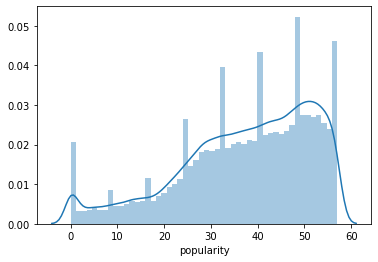

In [85]:
sns.distplot(df2['popularity'])

In [103]:
popular = df.loc[(df['p_popularity'] == 1)] 

In [104]:
unpopular = df2.sample(n=len(popular), random_state = 1)

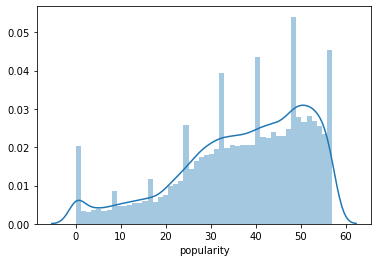

In [106]:
sns.distplot(unpopular['popularity'])

In [113]:
df = pd.concat([popular, unpopular]).sample(frac=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 89284 entries, 1mBqHMVnmMJQp3XKeUsEPh to 4VRRbrw7ai2mztUrXrAvfd
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   genre             89284 non-null  object 
 1   artist_name       89284 non-null  object 
 2   track_name        89284 non-null  object 
 3   popularity        89284 non-null  int64  
 4   acousticness      89284 non-null  float64
 5   danceability      89284 non-null  float64
 6   duration_ms       89284 non-null  int64  
 7   energy            89284 non-null  float64
 8   instrumentalness  89284 non-null  float64
 9   key               89284 non-null  object 
 10  liveness          89284 non-null  float64
 11  loudness          89284 non-null  float64
 12  mode              89284 non-null  object 
 13  speechiness       89284 non-null  float64
 14  tempo             89284 non-null  float64
 15  time_signature    89284 non-null  object 
 16  valence

In [114]:
df.tail()

,genre,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,p_popularity
track_id,,,,,,,,,,,,,,,,,,
7fxiVqfRHxo6L3Ijmm4FfH,Alternative,Roosevelt,Fever,47,0.030000,0.589,264031,0.778,0.005010,C,0.0833,-6.317,Major,0.0285,113.965,4/4,0.637,0.0
5UUmedFgpvlXmyydI0TqcX,Children’s Music,Skillet,Forgiven,49,0.136000,0.430,218533,0.883,0.000000,C,0.0967,-3.342,Major,0.0384,154.094,4/4,0.390,0.0
3VH68750Bk7kirESFY3EZE,Soul,Etta James,Misty,41,0.641000,0.421,195400,0.391,0.000004,C,0.2250,-9.780,Major,0.1020,66.371,4/4,0.206,0.0
5ExHDzOoOhC4xZGPh9zyQZ,Rap,Future,Shorty,65,0.245000,0.795,121000,0.386,0.000000,A#,0.0973,-10.638,Major,0.1800,131.971,4/4,0.619,1.0
4VRRbrw7ai2mztUrXrAvfd,Children’s Music,Godsmack,Bulletproof,62,0.000198,0.390,177048,0.910,0.000000,F,0.1560,-3.268,Minor,0.1330,162.253,4/4,0.644,1.0


#### Transformation & Normalization  
'mode'(Minor/Major), 'time_signature' (3/4, 4/4 etc.)

In [115]:
df["mode"] = df["mode"].astype('category')
df['mode'] = df['mode'].cat.codes

df["time_signature"] = df["time_signature"].astype('category')
df['time_signature'] = df['time_signature'].cat.codes

df["key"] = df["key"].astype('category')
df['key'] = df['key'].cat.codes

df["genre"] = df["genre"].astype('category')
df['genre'] = df['genre'].cat.codes

df.head(2)

,genre,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,p_popularity
track_id,,,,,,,,,,,,,,,,,,
1mBqHMVnmMJQp3XKeUsEPh,8,Ben Abraham,She,49,0.913,0.444,213013,0.296,0.001910,11,0.0957,-12.873,0,0.0388,138.516,2,0.260,0.0
6naxalmIoLFWR0siv8dnQQ,15,Britney Spears,Oops!...I Did It Again,77,0.300,0.751,211160,0.834,0.000018,4,0.3550,-5.444,1,0.0437,95.053,3,0.894,1.0


#### Splitting the data

In [116]:
Y_df = df['p_popularity']

X_df = df.drop(['popularity','p_popularity','artist_name','track_name','duration_ms'], axis=1)

scaling = MinMaxScaler(feature_range=(-1,1)).fit(X_df)
X_df = scaling.transform(X_df)

In [117]:
x_train, x_test, y_train, y_test = train_test_split(X_df, Y_df, test_size=0.30)


In [118]:
print(pd.DataFrame(X_df).head(2))

          0         1         2         3         4         5         6  \
0 -0.304348  0.833333 -0.166828 -0.407436 -0.996165  1.000000 -0.825908   
1  0.304348 -0.397590  0.495309  0.669663 -0.999964 -0.272727 -0.301185   

          7    8         9        10   11        12  
0  0.352706 -1.0 -0.965203  0.047738  0.0 -0.475806  
1  0.642093  1.0 -0.954806 -0.373375  0.5  0.802419  


### Logistic Regression

In [122]:
from sklearn.linear_model import LogisticRegression

In [123]:
logreg = LogisticRegression().fit(x_train,y_train)

In [124]:
log_pred=logreg.predict(x_test)

In [125]:
print(classification_report(y_test,log_pred))


              precision    recall  f1-score   support

         0.0       0.70      0.55      0.61     13382
         1.0       0.63      0.77      0.69     13404

    accuracy                           0.66     26786
   macro avg       0.66      0.66      0.65     26786
weighted avg       0.66      0.66      0.65     26786



In [19]:
print(confusion_matrix(y_test,log_pred))

[[53087   541]
 [13907   626]]


### Decision Tree

In [126]:
from sklearn.tree import DecisionTreeClassifier 


In [138]:
dtree = DecisionTreeClassifier(criterion = 'entropy')

In [139]:
dtree.fit(x_train,y_train)

DecisionTreeClassifier(criterion='entropy')

In [140]:
dtree_pred=dtree.predict(x_test)

In [141]:
print(classification_report(y_test,dtree_pred))
print('Confusion matrix')
print(confusion_matrix(y_test,dtree_pred))

              precision    recall  f1-score   support

         0.0       0.72      0.73      0.73     13382
         1.0       0.73      0.72      0.73     13404

    accuracy                           0.73     26786
   macro avg       0.73      0.73      0.73     26786
weighted avg       0.73      0.73      0.73     26786

Confusion matrix
[[9741 3641]
 [3709 9695]]


#### Balance of false negatives and false positives, neither high on precision or recall 
### Let's visualize the tree  

In [25]:
from sklearn import tree


In [26]:
features = df.drop(['popularity','artist_name','track_name','duration_ms'], axis=1)
feature_names = list(features.columns)

In [27]:
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (3,3), dpi = 5000)
### limiting max_depth to 2 for a more simple visual
tree.plot_tree(dtree, max_depth = 2, class_names = ['unpopular','popular'], feature_names = feature_names)

[Text(5812.5, 9909.375, 'loudness <= 0.453\nentropy = 0.755\nsamples = 159042\nvalue = [124471, 34571]\nclass = unpopular'),
 Text(2906.25, 7078.125, 'loudness <= 0.309\nentropy = 0.355\nsamples = 39891\nvalue = [37214, 2677]\nclass = unpopular'),
 Text(1453.125, 4246.875, 'danceability <= -0.339\nentropy = 0.191\nsamples = 21835\nvalue = [21194, 641]\nclass = unpopular'),
 Text(726.5625, 1415.625, '\n  (...)  \n'),
 Text(2179.6875, 1415.625, '\n  (...)  \n'),
 Text(4359.375, 4246.875, 'instrumentalness <= -0.054\nentropy = 0.508\nsamples = 18056\nvalue = [16020, 2036]\nclass = unpopular'),
 Text(3632.8125, 1415.625, '\n  (...)  \n'),
 Text(5085.9375, 1415.625, '\n  (...)  \n'),
 Text(8718.75, 7078.125, 'genre <= 0.708\nentropy = 0.838\nsamples = 119151\nvalue = [87257, 31894]\nclass = unpopular'),
 Text(7265.625, 4246.875, 'genre <= 0.208\nentropy = 0.881\nsamples = 102820\nvalue = [71994, 30826]\nclass = unpopular'),
 Text(6539.0625, 1415.625, '\n  (...)  \n'),
 Text(7992.1875, 1415.

### Random Forest 

In [131]:
rf = RandomForestClassifier(n_estimators = 250)

In [132]:
rf.fit(x_train,y_train)
rf_pred = rf.predict(x_test)

In [133]:
print(classification_report(y_test,rf_pred))
print('Confusion Matrix')
print(confusion_matrix(y_test,rf_pred))

              precision    recall  f1-score   support

         0.0       0.85      0.80      0.82     13382
         1.0       0.81      0.86      0.83     13404

    accuracy                           0.83     26786
   macro avg       0.83      0.83      0.83     26786
weighted avg       0.83      0.83      0.83     26786

Confusion Matrix
[[10684  2698]
 [ 1941 11463]]


Decent result with precision and recall being balanced and above 0.8

#### Confusion matrix visualized

Text(0.5, 1.0, 'Random Forest Confusion Matrix')

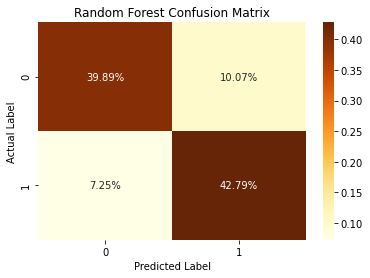

In [143]:
cm = confusion_matrix(y_test, rf_pred)

sns.heatmap(cm/np.sum(cm), annot=True, 
            fmt='.2%', cmap='YlOrBr')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Random Forest Confusion Matrix')

### AdaBoost

In [144]:
ada = AdaBoostClassifier(base_estimator = rf, n_estimators = 100)

In [145]:
ada.fit(x_train,y_train)
ada_pred = rf.predict(x_test)